In [70]:
import pandas as pd
import censusdata
import numpy as np 
import seaborn as sns
import pickle
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)

## Load in census data
I'll pull some basic demographics from the American Community Survey at the block group level, so we can link it with police precinct data. I referred to the [census bureau's table shells](https://www.census.gov/programs-surveys/acs/technical-documentation/summary-file-documentation.2015.html) tool to determine which fields to pull (note: some economic indicators, like median income, weren't available at the block group level). 

### Census Fields Needed

In [71]:
# create lists of census fields to pull
unemployment_fields = ['B23025_003E', 'B23025_005E']
edu_fields = ['B15003_001E', 'B15003_002E', 'B15003_003E','B15003_004E', 'B15003_005E', 'B15003_006E', 
              'B15003_007E', 'B15003_008E','B15003_009E', 'B15003_010E', 'B15003_011E', 'B15003_012E', 
              'B15003_013E','B15003_014E', 'B15003_015E', 'B15003_016E']
ethnicity_fields = ['B03002_003E','B03002_001E']

all_census_fields = ethnicity_fields + unemployment_fields + edu_fields

In [72]:
# create list of counties in NYC
nyc_counties = ['061','005','085','047','081']

### Pull Census Data

In [73]:
# pull data for just counties in NYC
nyc_counties = ['061','005','085','047','081']

results = pd.DataFrame()
for c in nyc_counties:
    county_results = censusdata.download('acs5', 2015,
                             censusdata.censusgeo([('state', '36'), ('county', c), ('block group', '*')]),
                             all_census_fields)
    results = results.append(county_results)

### Calculate final metrics

In [74]:
# number unemployed / number in civilian labor force
results['percent_unemployed'] = results.B23025_005E / results.B23025_003E * 100

# sum of those with any education less than high school diploma, divided by total population
results['percent_nohs'] = results[edu_fields[1:]].sum(axis=1) / results.B15003_001E * 100

# percentage of total who don't identify as latino, white alone
results['percent_poc'] = 100 - results.B03002_003E / results.B03002_001E * 100


results = results[['percent_unemployed', 'percent_nohs','percent_poc']]
results = results.reset_index()
results.head()

,index,percent_unemployed,percent_nohs,percent_poc
0,"Block Group 1, Census Tract 13, New York Count...",2.27,0.89,29.54
1,"Block Group 2, Census Tract 13, New York Count...",4.10,0.00,38.09
2,"Block Group 1, Census Tract 14.01, New York Co...",1.76,6.65,35.44
3,"Block Group 2, Census Tract 14.01, New York Co...",1.86,7.27,32.74
4,"Block Group 1, Census Tract 14.02, New York Co...",4.10,20.16,63.40


In [80]:
# create blockgroup IDs to align with the precinct data keys
blockgroups = []
for i in range(0,len(results)):
    geoid = results['index'][i].geo[0][1] + results['index'][i].geo[1][1] + results['index'][i].geo[2][1] + results['index'][i].geo[3][1]
    blockgroups.append(geoid)

results['blockgroup'] = blockgroups
results['blockgroup'] = results['blockgroup'].astype('int')
results.head()

,index,percent_unemployed,percent_nohs,percent_poc,blockgroup
0,"Block Group 1, Census Tract 13, New York Count...",2.27,0.89,29.54,360610013001
1,"Block Group 2, Census Tract 13, New York Count...",4.10,0.00,38.09,360610013002
2,"Block Group 1, Census Tract 14.01, New York Co...",1.76,6.65,35.44,360610014011
3,"Block Group 2, Census Tract 14.01, New York Co...",1.86,7.27,32.74,360610014012
4,"Block Group 1, Census Tract 14.02, New York Co...",4.10,20.16,63.40,360610014021


## Load precinct data and merge to create final dataset
I'm using [this key](https://johnkeefe.net/nyc-police-precinct-and-census-data) from John Keefe that links census blocks to police precincts.

In [81]:
# load in block <--> precinct crosswalk
precincts = pd.read_csv('precinct_block_key_2020.csv')

# the file gives us blocks, we'll turn these into block groups to match census data
precincts['blockgroup'] = precincts['geoid10'].astype(str).str[:-3].astype(np.int64)
precincts.head()

,geoid10,precinct_2020,blockgroup
0,360050001000001,NaN,360050001000
1,360050001000002,NaN,360050001000
2,360050001001000,114.0,360050001001
3,360050001001001,114.0,360050001001
4,360050001001002,114.0,360050001001


In [82]:
# add precinct to the results dataframe
results = pd.merge(left=results,right=precincts,how='left',on='blockgroup')

In [83]:
results.head()

,index,percent_unemployed,percent_nohs,percent_poc,blockgroup,geoid10,precinct_2020
0,"Block Group 1, Census Tract 13, New York Count...",2.27,0.89,29.54,360610013001,360610013001000,1.0
1,"Block Group 1, Census Tract 13, New York Count...",2.27,0.89,29.54,360610013001,360610013001001,1.0
2,"Block Group 1, Census Tract 13, New York Count...",2.27,0.89,29.54,360610013001,360610013001002,1.0
3,"Block Group 1, Census Tract 13, New York Count...",2.27,0.89,29.54,360610013001,360610013001003,1.0
4,"Block Group 1, Census Tract 13, New York Count...",2.27,0.89,29.54,360610013001,360610013001004,1.0


In [14]:
# groupby precinct, taking average and median of our metrics
results.groupby('precinct_2020').agg({'percent_unemployed': ['mean','median'],'percent_nohs': ['mean','median']}).head()

percent_unemployed        percent_nohs       
                            mean median         mean median
precinct_2020                                              
1.0                         3.49   2.80         2.82   1.45
5.0                         6.85   6.49        31.23  28.88
6.0                         4.65   4.06         1.01   0.06
7.0                         8.51   7.38        27.21  26.00
9.0                         7.00   5.26        13.85   7.55

In [86]:
# create dataframe from groupby
census_df = results.groupby('precinct_2020').agg({'percent_unemployed': ['mean','median'],'percent_nohs': ['mean','median'],'percent_poc': ['mean','median']})

# rename columns and reset index
census_df.columns = ['percent_unemployed_mean','percent_unemployed_median',
                    'percent_nohs_mean', 'percent_nohs_median','percent_poc_mean','percent_poc_median']
census_df = census_df.reset_index()
census_df.head()

,precinct_2020,percent_unemployed_mean,percent_unemployed_median,percent_nohs_mean,percent_nohs_median,percent_poc_mean,percent_poc_median
0,1.0,3.49,2.80,2.82,1.45,28.48,30.60
1,5.0,6.85,6.49,31.23,28.88,72.82,84.97
2,6.0,4.65,4.06,1.01,0.06,18.79,17.53
3,7.0,8.51,7.38,27.21,26.00,71.96,77.23
4,9.0,7.00,5.26,13.85,7.55,48.53,37.54


## Inspect Data for outliers and multicollinearity

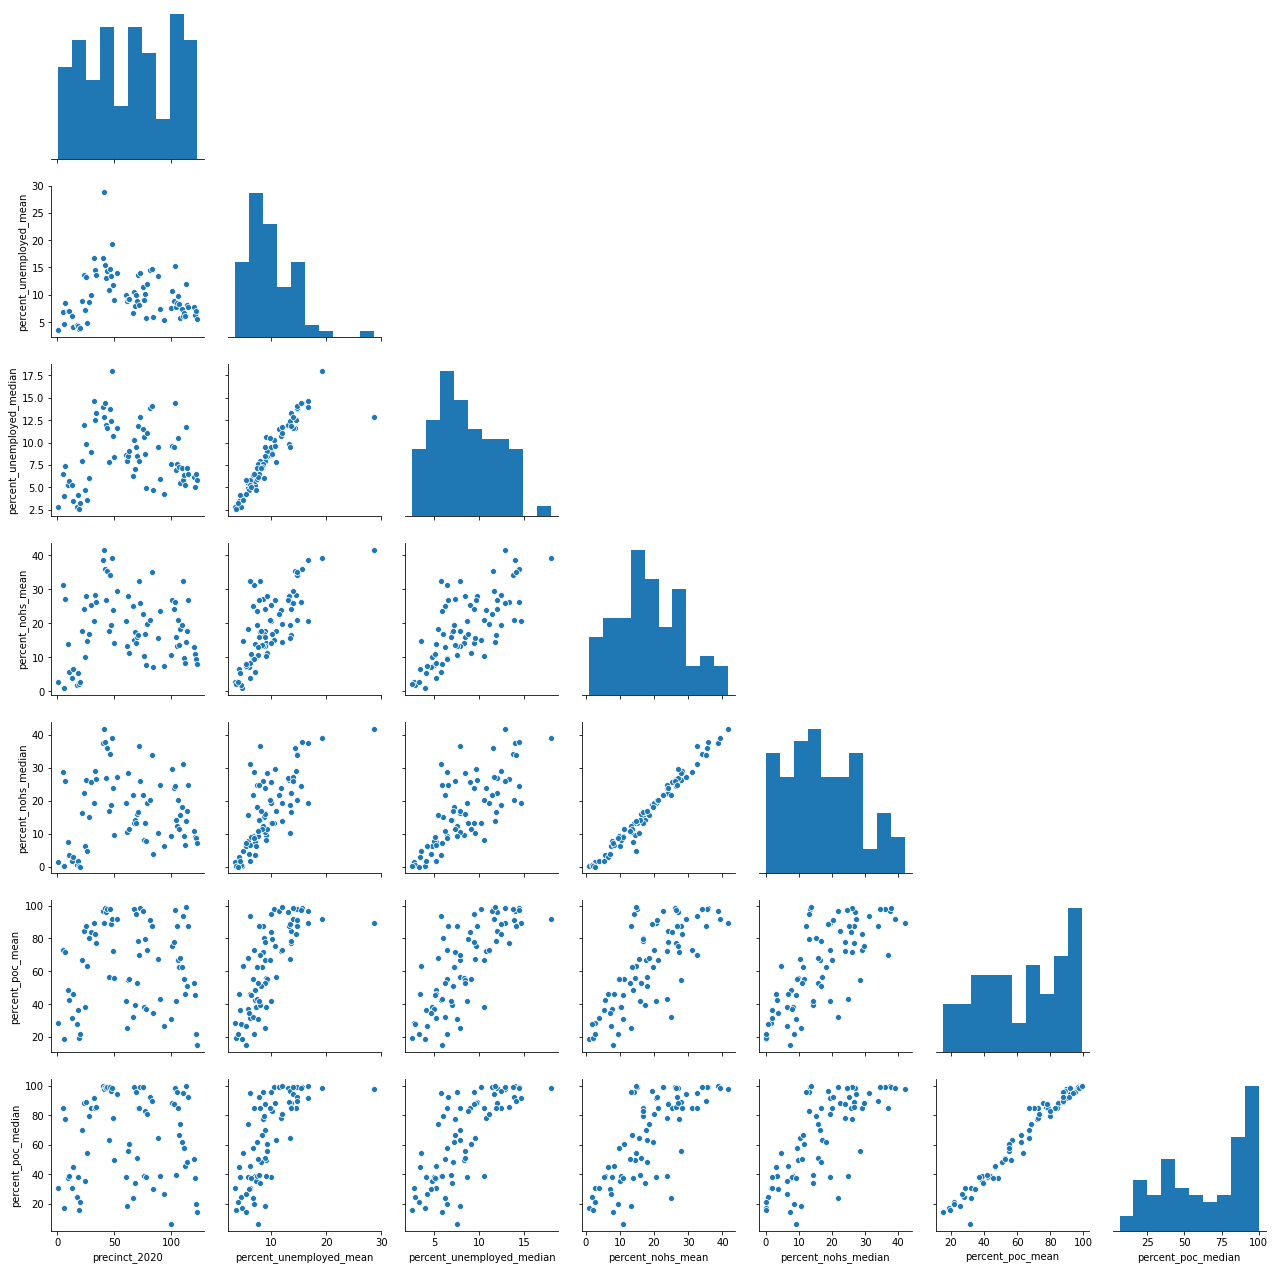

In [124]:
sns.pairplot(census_df,corner=True);

In [116]:
census_df.isna().sum()

precinct_2020                0
percent_unemployed_mean      1
percent_unemployed_median    1
percent_nohs_mean            1
percent_nohs_median          1
percent_poc_mean             1
percent_poc_median           1
dtype: int64

Observations:
- percent no high school and percent poc are linearly related; noting this for feature selection
- one precinct has 100% unemployment -- that can't be correct

In [90]:
# inspect the erroneous record
census_df[census_df['percent_unemployed_mean']==100]

,precinct_2020,percent_unemployed_mean,percent_unemployed_median,percent_nohs_mean,percent_nohs_median,percent_poc_mean,percent_poc_median
12,22.0,100.0,100.0,50.0,50.0,100.0,100.0


In [122]:
# turns out the 22nd precinct is central park. I'm simply going to replace the values with the median from the entire dataset
census_df.iloc[12,1:].replace([100,50,100],np.NaN,inplace=True)
census_df.fillna(census_df.median(),inplace=True)
census_df.iloc[12]

precinct_2020                22.00
percent_unemployed_mean       8.85
percent_unemployed_median     7.91
percent_nohs_mean            17.61
percent_nohs_median          16.30
percent_poc_mean             67.21
percent_poc_median           70.32
Name: 12, dtype: float64

## Export final dataset as pickle

In [125]:
with open('final_census_data.pickle', 'wb') as to_write:
    pickle.dump(census_df, to_write)